# Subway Data Analysis

## Introduction

The New York System of bus and trains - Metro Transit Authority - provides its data for download through csv files. One of the available information is the data of ticket gates which contains weekly logs of cumulative entries and exits for each ticket gate for each metro station in some time interval.


In this project, I will only use information about the ticket gates available at: http://web.mta.info/developers/turnstile.html.



# About this project

In this project, I will acquire data, clean it and throughout the process we will discove things about the data.

The project's purpose is to explore how the NYC's subway use and the weather on a specific day relate. For that, apart from data from the subway, we will need data about the climate on the very day.

The main points of this project are: 
- Data collection from internet;
- Data Analysis.
- Data manipulation and creation of simple graphics with Pandas.

## Section 1 - Data Collection

This code will access the link: http://web.mta.info/developers/turnstile.html and download the files from June 2017. The archive will be saved as turnstile_100617.txt - where 10/06/17 is the date of the archive.


In [1]:
# import urllib
import urllib.request
from bs4 import BeautifulSoup

ur = "http://web.mta.info/developers/turnstile.html"
ur_base = "http://web.mta.info/developers/" 
u = urllib.request.urlopen(ur)
html = u.read()

soup = BeautifulSoup(html, "html.parser")
links = soup.find_all('a')
for link in links:
    if link.get('href') and '1706' in link.get('href'):
        url_file = ur_base + link.get('href')
        sitestring = str(link.get('href'))
        begin = sitestring.find("1706")
        filename = "turnstile_" + sitestring[begin:begin+7] + "txt"
        urllib.request.urlretrieve(url_file, filename)
        
        
    

This code is a function who takes the name list from archives you downloaded in the previous cell and combine them onto an unique archive.


In [2]:
def create_master_turnstile_file(filenames, output_file):
    with open(output_file, 'w') as master_file:
        master_file.write('C/A,UNIT,SCP,STATION, LINENAME, DIVISION, DATEn,TIMEn,DESCn,ENTRIESn,EXITSn\n')
        for filename in filenames:
            with open(filename) as filename:
                for eachone in filename:
                    if "A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS" in eachone:
                        eachone=""
                        eachone.rstrip()
                        master_file.write(eachone)
                    else:
                        master_file.write(eachone)
                    
 
       
filenames = ["turnstile_170603.txt", "turnstile_170610.txt", "turnstile_170617.txt", "turnstile_170624.txt"]  
output_file = "all_files.txt"
create_master_turnstile_file(filenames, output_file)   

This code will read the master_file created previously and load it into a Pandas dataframe. The function will filter for that the dataframe gets only the lines whose the column "DESCn" is equal to "Regular".

In [3]:
import pandas as pd
import csv
def filter_by_regular(filename):
    result = pd.read_csv(filename)
    result = pd.DataFrame(result)
    result = result[result['DESCn'] == 'REGULAR']
    return result

filter_regular = filter_by_regular('all_files.txt')

The NYC subway has input and output cumulative data by line. This function will make a new column called ENTRIESn_hourly and take into this column the difference between ENTRIESn of the actual line and ENTRIESn of the previous line. 

In [4]:
import pandas

def get_hourly_entries(df):
    day_change = df['ENTRIESn'].shift(1)
    df['ENTRIESn_hourly'] =  (df['ENTRIESn'] - day_change).fillna(1)
    return df

get_hourly = get_hourly_entries(filter_regular)

This function will make a new column called EXITSn_hourly and take into this column the difference between EXITSn of the actual line and ENTRIESn of the previous line. If there is some NaN, it will fill the space with 0.



In [5]:
import pandas

def get_hourly_exits(df):
    day_exchange = df['EXITSn'].shift(1)
    df['EXITSn_hourly'] = (df['EXITSn'] - day_exchange).fillna(0)
    return df
get_exits = get_hourly_exits(get_hourly)

This function will take a variable that represents the time in the format "00:00:00" (hour: minutes: seconds) and pull out the hour part of the time variable as an entire number.

In [6]:
import pandas as pd
def time_to_hour(time): 
        result = []
        xc = time
        list = xc.split(":")
        result.append(list[0])
        for i in result:
            if i[0] == "0":
                result[0] = i[1]
        hour = result[0]
        return hour
time_to_hour('06:00:00')

'6'

### Data Analysis 

To understand the link between the use of the Subway and the weather, we need to combine the archive's data already downloaded with the weather data.

The weather data can be accessed by the link: https://s3.amazonaws.com/content.udacity-data.com/courses/ud359/turnstile_data_master_with_weather.csv
```



In [8]:
import pandas as pd

filename = "turnstile_data_master_with_weather.csv"
Dataframe = pd.read_csv(filename, sep=",")
Dataframe = pd.DataFrame(Dataframe)

Dataframe['DATEn'] = pd.to_datetime(Dataframe['DATEn'])
print(Dataframe)




        Unnamed: 0  UNIT      DATEn     TIMEn  Hour    DESCn  ENTRIESn_hourly  \
0                0  R001 2011-05-01  01:00:00     1  REGULAR              0.0   
1                1  R001 2011-05-01  05:00:00     5  REGULAR            217.0   
2                2  R001 2011-05-01  09:00:00     9  REGULAR            890.0   
3                3  R001 2011-05-01  13:00:00    13  REGULAR           2451.0   
4                4  R001 2011-05-01  17:00:00    17  REGULAR           4400.0   
5                5  R001 2011-05-01  21:00:00    21  REGULAR           3372.0   
6                6  R002 2011-05-01  01:00:00     1  REGULAR              0.0   
7                7  R002 2011-05-01  05:00:00     5  REGULAR             42.0   
8                8  R002 2011-05-01  09:00:00     9  REGULAR             50.0   
9                9  R002 2011-05-01  13:00:00    13  REGULAR            316.0   
10              10  R002 2011-05-01  17:00:00    17  REGULAR            633.0   
11              11  R002 201

This function will figure out the amount of rainy days.

In [9]:

def num_rainy_days(df):
    number_days = df.DATEn[(Dataframe['rain'] == 1)]
    one_key = None
    number  = 0
    for each in number_days:
        if each != one_key:
            number +=1
            one_key = each

    
    return number
num_rainy_days(Dataframe)

10

This function returns the nebulous days' maximum temperature.

In [10]:
def max_temp_aggregate_by_fog(df):
    g = df.groupby('fog')['maxtempi'].max()
    return g
    
max_temp_aggregate_by_fog(Dataframe)

fog
0.0    86.0
1.0    81.0
Name: maxtempi, dtype: float64

This function figures out the meantempi's mean on Saturday and Sunday.

In [11]:
import pandas as pd
def avg_weekend_temperature(df):
    df['DATEn'] = pd.to_datetime(Dataframe['DATEn'])
    DaysWeek = df['DATEn'].dt.dayofweek
    mean_temp_weekends = (df.meantempi[(DaysWeek == 5) | (DaysWeek == 6)]).mean()
    
    return mean_temp_weekends
avg_weekend_temperature(Dataframe)

65.10066685403307

This function figures out the mean of minimum temperatures on rainy days where the min temperature is higher than 55 degrees.

In [12]:
def avg_min_temperature(df):
    avg_min_temp_rainy = (df.mintempi[(Dataframe['rain'] == 1) & (df['mintempi'] > 55)]).mean()
    return avg_min_temp_rainy
avg_min_temperature(Dataframe)

61.238860398860396

This code will plot two histograms on the same axis to show when it is raining vs when it is not raining.    

<module 'matplotlib.pyplot' from '/home/richson/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

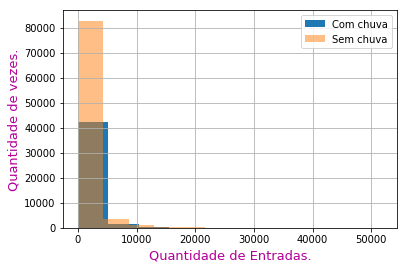

In [13]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
def entries_histogram(turnstile_weather):
    
    plt.figure()
    x = (turnstile_weather['ENTRIESn_hourly'][turnstile_weather['rain'] == 1]).hist(label="Com chuva") # your code here to plot a historgram for hourly entries when it is raining
    y = (turnstile_weather['ENTRIESn_hourly'][turnstile_weather['rain'] == 0]).hist(label="Sem chuva", alpha = 0.5) # your code here to plot a histogram for hourly entries when it is not raining
    plt.xlabel("Quantidade de Entradas.", fontsize=13, color =	 (0.7, 0, 0.6))
    plt.ylabel('Quantidade de vezes.', fontsize=13, color = (0.7, 0, 0.6))
    plt.legend()
    return plt
entries_histogram(Dataframe)

### *Exercicio 2.7

Qual é a distribuição dos dados plotados? Are there differences between rainy days and non rainy dias?

** Answer **: Skewed Right. Apparently, not.

This function returns the mean of entries from rainy days and non rainy days.

In [14]:
import numpy as np

import pandas

def means(turnstile_weather):
    
    with_rain_mean = (turnstile_weather['ENTRIESn_hourly'][turnstile_weather['rain'] == 1]).mean()
    without_rain_mean = (turnstile_weather['ENTRIESn_hourly'][turnstile_weather['rain'] == 0]).mean()
    return with_rain_mean, without_rain_mean # leave this line for the grader

means(Dataframe)

(1105.4463767458733, 1090.278780151855)

What is the mean of entries with rain? What is the mean of entries without rain?


** Answer **: 1 - 1105.4463767458733
                2 - 1090.278780151855

## Map Reduce

This is a code used as mapper.

For each entry line, the output will print a UNIT as a key and ENTRIESn_hourly as the value.



In [16]:
import sys

def mapper():
    for line in sys.stdin:
        thedata = line.strip().split(',')
        if len(thedata) == 22:
            Index,UNIT,DATEn,TIMEn,Hour,DESCn,ENTRIESn_hourly,EXITSn_hourly,maxpressurei,maxdewpti,mindewpti,minpressurei,meandewpti,meanpressurei,fog,rain,meanwindspdi,mintempi,meantempi,maxtempi,precipi,thunder = thedata
            if type(UNIT) == str:
                if UNIT != "UNIT":
                    print("{0}\t{1}".format(UNIT, ENTRIESn_hourly))
        
sys.stdin = open('turnstile_data_master_with_weather.csv')
sys.stdout = open('mapper_result.txt', 'w')
mapper()

This is a code used as reducer.

It will use the earlier mapper's result, and print one line per unit - along with the total number of ENTRIESn_hourly. 

In [17]:
def reducer():
    Entries_Total = 0
    Old_Key = None
    

    for line in sys.stdin:
        data = line.split('\t')
            
        
        if len(data) != 2:
            continue
        key, value = data
        if Old_Key and Old_Key != key :
            print("{0}\t{1}".format(Old_Key, Entries_Total))
            Entries_Total = 0       
        Entries_Total+= float(value)
        Old_Key = key
                          
        
        

sys.stdin = open('mapper_result.txt')
sys.stdout = open('reducer_result.txt', 'w')
reducer()
